The following application is inspired by the empirical example in "Measuring the model risk-adjusted performance of machine learning algorithms in credit default prediction" by @AlonsoRobisco2022. However, since we are not interested in model risk-adjusted performance, the application will purely focus on the implementation of machine learning algorithms for loan default prediction.

## Problem Setup

The dataset that we will be using was used in the Kaggle competition ["Give Me Some Credit"](https://www.kaggle.com/c/GiveMeSomeCredit). The description of the competition reads as follows:

>Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. 
>
>Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted. This competition requires participants to improve on the state of the art in credit scoring, by predicting the probability that somebody will experience financial distress in the next two years.
>
>The goal of this competition is to build a model that borrowers can use to help make the best financial decisions.
>
>Historical data are provided on 250,000 borrowers and the prize pool is $5,000 ($3,000 for first, $1,500 for second and $500 for third).

Unfortunately, there won't be any prize money today. However, the experience that you can gain from working through an application like this can be invaluable. So, in a way, you are still winning!


## Dataset

Let's download the dataset automatically, unzip it, and place it in a folder called `data` if you haven't done so already

In [1]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import os.path

# Check if the file exists
if not os.path.isfile('data/Data Dictionary.xl') or not os.path.isfile('data/cs-training.csv'):

    print('Downloading dataset...')

    # Define the dataset to be downloaded
    zipurl = 'https://www.kaggle.com/api/v1/datasets/download/brycecf/give-me-some-credit-dataset'

    # Download and unzip the dataset in the data folder
    with urlopen(zipurl) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall('data')

    print('DONE!')

else:

    print('Dataset already downloaded!')

DONE!


Then, we can have a look at the data dictionary that is provided with the dataset. This will give us an idea of the variables that are available in the dataset and what they represent

In [2]:
import pandas as pd
data_dict = pd.read_excel('data/Data Dictionary.xls', header=1)
data_dict.style.hide()

Variable Name,Description,Type
SeriousDlqin2yrs,Person experienced 90 days past due delinquency or worse,Y/N
RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits,percentage
age,Age of borrower in years,integer
NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,integer
DebtRatio,"Monthly debt payments, alimony,living costs divided by monthy gross income",percentage
MonthlyIncome,Monthly income,real
NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards),integer
NumberOfTimes90DaysLate,Number of times borrower has been 90 days or more past due.,integer
NumberRealEstateLoansOrLines,Number of mortgage and real estate loans including home equity lines of credit,integer
NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days past due but no worse in the last 2 years.,integer


The variable $y$ that we want to predict is `SeriousDlqin2yrs` which indicates whether a person has been 90 days past due on a loan payment (serious delinquency) in the past two years. This target variable is $1$ if the loan defaults (i.e., serious delinquency occured) and $0$ if the loan does not default (i.e., no serious delinquency occured) . The other variables are features that we can use to predict this target variable such as the age of the borrower and the monthly income of the borrower.


## Putting the Problem into the Context of the Course

Given the description of the competition and the dataset, we can see that this is a **supervised learning problem**. We have a target variable that we want to predict, and we have features that we can use to predict this target variable. The target variable is binary, i.e., it can take two values: 0 or 1. The value 0 indicates that the loan will not default, while the value 1 indicates that the loan will default. Thus, this is a **binary classification problem**.


## Setting up the Environment

We will start by setting up the environment by importing the necessary libraries 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

and loading the dataset

In [4]:
df = pd.read_csv('data/cs-training.csv')

Let's also download some precomputed models that we will use later on

In [5]:
for file_name in ['clf_nn.joblib', 'clf_nn2.joblib']:

    if not os.path.isfile(file_name):

        print(f'Downloading {file_name}...')

        # Generate the download link
        url = f'https://github.com/jmarbet/data-science-course/raw/main/notebooks/{file_name}'

        # Download the file
        with urlopen(url) as response, open(file_name, 'wb') as out_file:
            data = response.read()
            out_file.write(data)

        print('DONE!')

    else:

        print(f'{file_name} already downloaded!')

clf_nn.joblib already downloaded!
clf_nn2.joblib already downloaded!


## Data Preprocessing

The dataset is now loaded into a pandas DataFrame. Let's have a look at the first few rows of the dataset to get an idea of what the data looks like.

In [6]:
df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


The column `Unnamed: 0` seems to be a superfluous index column that we could drop. Let's do that

In [7]:
df = df.drop('Unnamed: 0', axis=1)

Furthermore, the order of the column names in the dataset is not very intuitive. Let's reorder the columns in the dataset 

In [8]:
orderedList = [
    'SeriousDlqin2yrs',
    'age', 
    'NumberOfDependents',
    'MonthlyIncome', 
    'DebtRatio',
    'RevolvingUtilizationOfUnsecuredLines',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberRealEstateLoansOrLines',
    'NumberOfTime30-59DaysPastDueNotWorse', 
    'NumberOfTime60-89DaysPastDueNotWorse', 
    'NumberOfTimes90DaysLate'
]

df = df.loc[:, orderedList]

Let's also have a look at the data types of the columns in the dataset and whether there are any missing values

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   age                                   150000 non-null  int64  
 2   NumberOfDependents                    146076 non-null  float64
 3   MonthlyIncome                         120269 non-null  float64
 4   DebtRatio                             150000 non-null  float64
 5   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberRealEstateLoansOrLines          150000 non-null  int64  
 8   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfTimes90DaysLate               150000 non-null  int64  
dtype

Note that the column `MonthlyIncome` and `NumberOfDependents` seem to have missing values. Before we drop these missing values or impute them, let's have a look at the distribution of our target variable `SeriousDlqin2yrs`

In [10]:
df['SeriousDlqin2yrs'].value_counts(normalize=True)

SeriousDlqin2yrs
0    0.93316
1    0.06684
Name: proportion, dtype: float64

As with the example that we have seen during one of our previous lectures, the dataset seems to be quite imbalanced. Only about 6.7% of the loans have defaulted. This is something that we need to keep in mind when treating the missing values and when building our models.

Let's see what happens to the distribution of the target variable if we drop the missing values

In [11]:
df.dropna().value_counts("SeriousDlqin2yrs", normalize=True)

SeriousDlqin2yrs
0    0.930514
1    0.069486
Name: proportion, dtype: float64

It seems to have almost no impact on the distribution of the target variable. This is good news. Let's compare some other statistics of the dataset before and after dropping the missing values

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfDependents,146076.0,0.757222,1.115086,0.0,0.000000,0.000000,1.000000,20.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


In [13]:
df.dropna().describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,120269.0,0.069486,0.254280,0.0,0.000000,0.000000,0.000000,1.0
age,120269.0,51.289792,14.426684,0.0,40.000000,51.000000,61.000000,103.0
NumberOfDependents,120269.0,0.851832,1.148391,0.0,0.000000,0.000000,2.000000,20.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
DebtRatio,120269.0,26.598777,424.446457,0.0,0.143388,0.296023,0.482559,61106.5
RevolvingUtilizationOfUnsecuredLines,120269.0,5.899873,257.040685,0.0,0.035084,0.177282,0.579428,50708.0
NumberOfOpenCreditLinesAndLoans,120269.0,8.758475,5.172835,0.0,5.000000,8.000000,11.000000,58.0
NumberRealEstateLoansOrLines,120269.0,1.054519,1.149273,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime30-59DaysPastDueNotWorse,120269.0,0.381769,3.499234,0.0,0.000000,0.000000,0.000000,98.0
NumberOfTime60-89DaysPastDueNotWorse,120269.0,0.187829,3.447901,0.0,0.000000,0.000000,0.000000,98.0


It looks like the statistics before and after dropping the missing values are quite similar, except for the variable `DebtRatio`, where we have substantially lower means and standard deviation. Let's also have a look at the distribution of the variables for the rows that we have dropped

In [14]:
df.loc[df.isna().any(axis=1)].describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,29731.0,0.056137,0.230189,0.0,0.000000,0.000000,0.000000,1.0
age,29731.0,56.362349,15.438786,21.0,46.000000,57.000000,67.000000,109.0
NumberOfDependents,25807.0,0.316310,0.809944,0.0,0.000000,0.000000,0.000000,9.0
MonthlyIncome,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DebtRatio,29731.0,1673.396556,4248.372895,0.0,123.000000,1159.000000,2382.000000,329664.0
RevolvingUtilizationOfUnsecuredLines,29731.0,6.649421,217.814854,0.0,0.016027,0.081697,0.440549,22198.0
NumberOfOpenCreditLinesAndLoans,29731.0,7.216071,4.842720,0.0,4.000000,6.000000,10.000000,45.0
NumberRealEstateLoansOrLines,29731.0,0.871481,1.034291,0.0,0.000000,1.000000,1.000000,23.0
NumberOfTime30-59DaysPastDueNotWorse,29731.0,0.579866,6.255361,0.0,0.000000,0.000000,0.000000,98.0
NumberOfTime60-89DaysPastDueNotWorse,29731.0,0.452995,6.242076,0.0,0.000000,0.000000,0.000000,98.0


Again, the mean of the dropped rows seems to be substantially higher for the variable `DebtRatio` suggesting that the missing values are not missing entirely at random. Note, however, that the standard deviation is lower meaning that the dropped observations are more similar to each other in the `DebtRatio` dimension. From our data dictionary, we know that the `DebtRatio` is defined as

In [15]:
data_dict.loc[data_dict['Variable Name'] == 'DebtRatio'].style.hide()

Variable Name,Description,Type
DebtRatio,"Monthly debt payments, alimony,living costs divided by monthy gross income",percentage


So, it seems that the `DebtRatio` is the ratio of the monthly debt payments to the monthly gross income. We actually have `MonthlyIncome` in our dataset!

In [16]:
data_dict.loc[data_dict['Variable Name'] == 'MonthlyIncome'].style.hide()

Variable Name,Description,Type
MonthlyIncome,Monthly income,real


It does not say whether this is in gross or net terms though. Nevertheless, let's have a look at the relationship between the `DebtRatio` and the `MonthlyIncome`

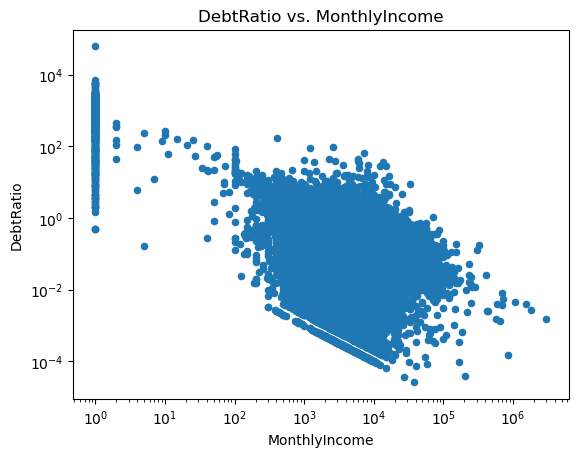

In [17]:
ax = df.plot.scatter(x='MonthlyIncome', y='DebtRatio')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('MonthlyIncome')
ax.set_ylabel('DebtRatio')
ax.set_title('DebtRatio vs. MonthlyIncome')
plt.show()

This looks rather odd. Note how there are a lot of monthly incomes that are close to zero. Furthermore, there is a weird gap going through the scatter points. We can look at the descriptive statistics of the rows with `MonthlyIncome` less than 100

In [18]:
df.query('MonthlyIncome <= 100').describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,2301.0,0.036506,0.187586,0.0,0.000000,0.000000,0.000000,1.0
age,2301.0,47.740113,16.199176,21.0,35.000000,46.000000,60.000000,103.0
NumberOfDependents,2301.0,0.778792,1.192441,0.0,0.000000,0.000000,2.000000,10.0
MonthlyIncome,2301.0,1.837027,11.408271,0.0,0.000000,0.000000,1.000000,100.0
DebtRatio,2301.0,1370.529300,2752.843610,0.0,79.000000,732.000000,1850.500000,61106.5
RevolvingUtilizationOfUnsecuredLines,2301.0,3.604101,125.553453,0.0,0.022243,0.113149,0.486629,5893.0
NumberOfOpenCreditLinesAndLoans,2301.0,7.171230,4.869628,0.0,4.000000,6.000000,10.000000,31.0
NumberRealEstateLoansOrLines,2301.0,0.742721,0.904984,0.0,0.000000,1.000000,1.000000,9.0
NumberOfTime30-59DaysPastDueNotWorse,2301.0,0.549326,6.132226,0.0,0.000000,0.000000,0.000000,98.0
NumberOfTime60-89DaysPastDueNotWorse,2301.0,0.428509,6.124274,0.0,0.000000,0.000000,0.000000,98.0


These observations seem to have a higher `debtRatio` than the rest of the dataset but are less likely to default on their loans (the mean of `SeriousDlqin2yrs` is equal to the fraction of defaulting loans). Given that they have no income (or essentially no income), this seems rather odd and is likely due to an error during data entry/collection. Since there are only a small number of observations with `MonthlyIncome` less than 100, we can probably drop them.  Let's look at the same figure for `MonthlyIncome` greater than 100

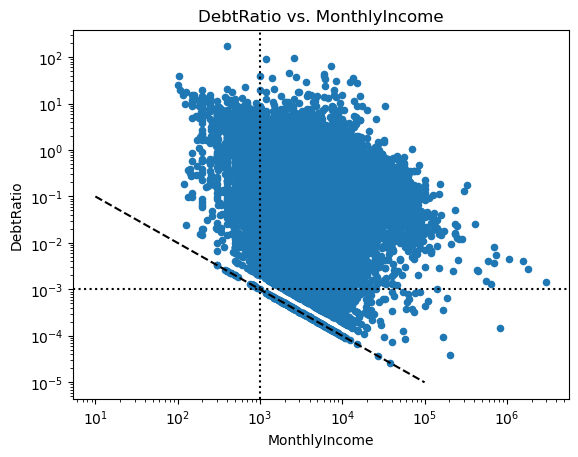

In [19]:
ax = df.query('MonthlyIncome > 100').plot.scatter(x='MonthlyIncome', y='DebtRatio')
ax.set_xscale('log')
ax.set_yscale('log')
ax.axvline(10**3, color='black', linestyle=':')
ax.axhline(10**(-3), color='black', linestyle=':')
ax.plot([10, 10**5], [10**(-1), 10**(-5)], color='black', linestyle='--')
ax.set_xlabel('MonthlyIncome')
ax.set_ylabel('DebtRatio')
ax.set_title('DebtRatio vs. MonthlyIncome')
plt.show()

This looks better but note how the scatter points below the gap seem to line up with the line $\frac{1}{\text{MonthlyIncome}}$. Thus, there seems to be another potential data entry/collection error since the debt in the raw data has likely been just set to $1$ for these observations. If this was a real dataset, we would need to investigate this further and maybe talk to the people who have sent us the data. However, given that this is just an example, we leave it as is.

Let's also have a look at the distribution of `DebtRatio` variable

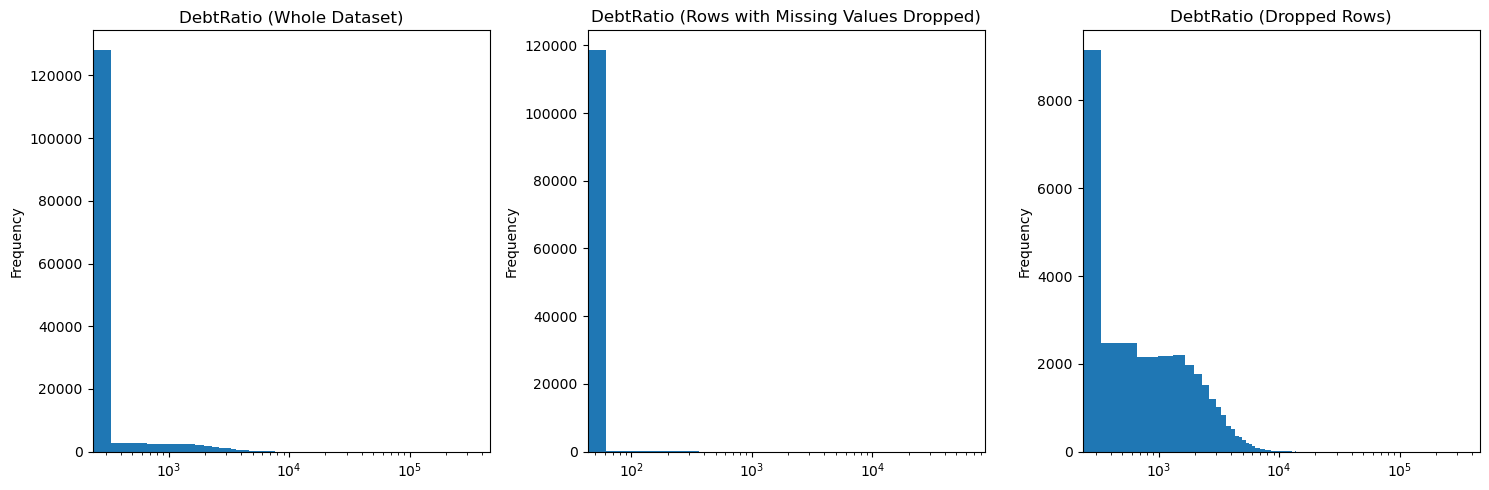

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

df['DebtRatio'].plot.hist(bins=1000, ax=ax[0])
df.dropna()['DebtRatio'].plot.hist(bins=1000, ax=ax[1])
df.loc[df.isna().any(axis=1), 'DebtRatio'].plot.hist(bins=1000, ax=ax[2])

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')

ax[0].set_title('DebtRatio (Whole Dataset)')
ax[1].set_title('DebtRatio (Rows with Missing Values Dropped)')
ax[2].set_title('DebtRatio (Dropped Rows)')

fig.tight_layout()
plt.show()

Where we can again see the high `DebtRatio` values for the rows with missing values. We can also have a look at the distribution of all the variables in the dataset

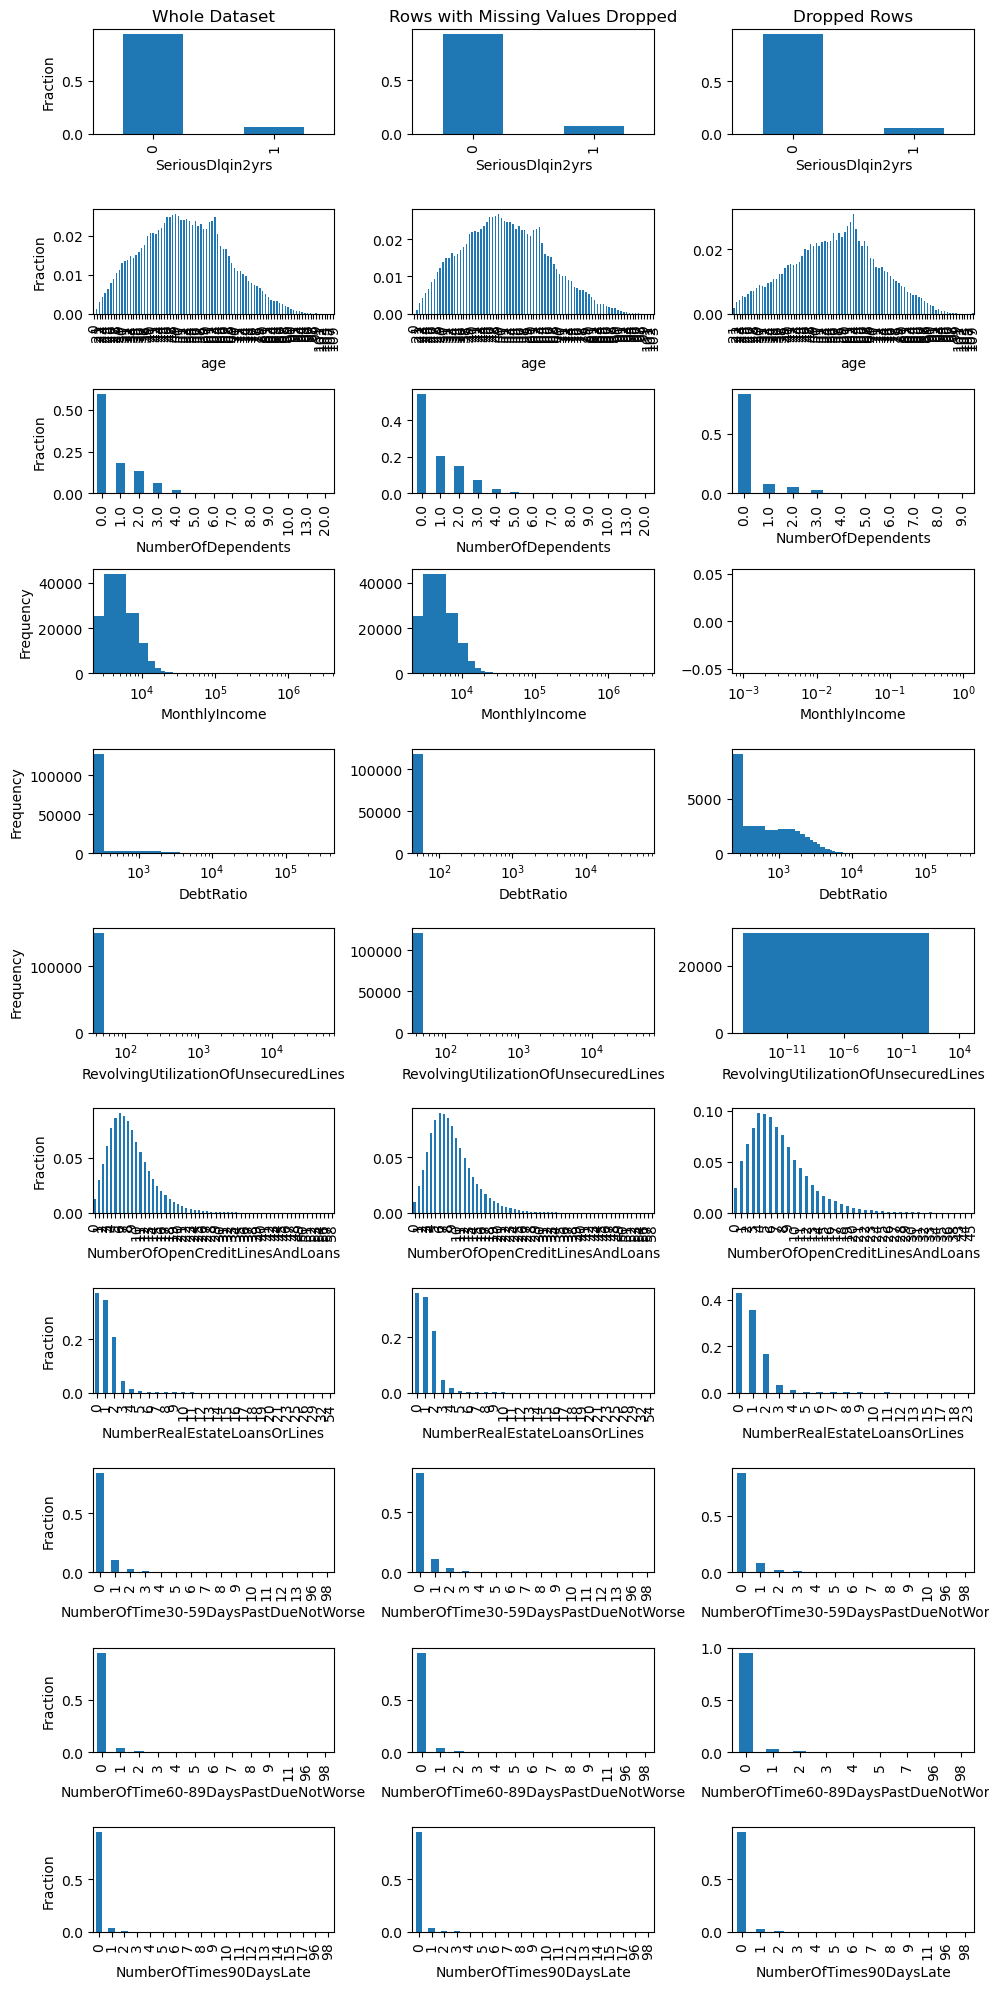

In [21]:
fig, ax = plt.subplots(df.shape[1], 3, figsize=(10, 20))

for ii, col in enumerate(df.columns):

    # Plot the distribution of the variable for the whole dataset, the dataset with missing values dropped, and the dropped rows
    if col in ('SeriousDlqin2yrs', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents'): 

        # Use a bar plot for discrete variables
        df[col].value_counts(normalize=True).sort_index().plot.bar(ax=ax[ii,0])
        df.dropna()[col].value_counts(normalize=True).sort_index().plot.bar(ax=ax[ii,1])
        df.loc[df.isna().any(axis=1), col].value_counts(normalize=True).sort_index().plot.bar(ax=ax[ii,2])

        # Set the y-axis label
        ax[ii,0].set_ylabel('Fraction')
        ax[ii,1].set_ylabel('')
        ax[ii,2].set_ylabel('')

    else:

        # Use a histogram for continuous variables
        df[col].plot.hist(bins=1000, ax=ax[ii,0])
        df.dropna()[col].plot.hist(bins=1000, ax=ax[ii,1])
        df.loc[df.isna().any(axis=1), col].plot.hist(bins=1000, ax=ax[ii,2])

        # Set the x-axis to a logarithmic scale for the continuous variables
        ax[ii,0].set_xscale('log')
        ax[ii,1].set_xscale('log')
        ax[ii,2].set_xscale('log')

        # Set the x-axis label
        ax[ii,0].set_xlabel(col)
        ax[ii,1].set_xlabel(col)
        ax[ii,2].set_xlabel(col)

        # Set the y-axis label
        ax[ii,0].set_ylabel('Frequency')
        ax[ii,1].set_ylabel('')
        ax[ii,2].set_ylabel('')

ax[0,0].set_title('Whole Dataset')
ax[0,1].set_title('Rows with Missing Values Dropped')
ax[0,2].set_title('Dropped Rows')

fig.tight_layout()
plt.show()

This shows another potential issue with our dataset. Checkout the variable `NumberOfTime30-59DaysPastDueNotWorse`. It seems that there are a some observations with values greater than 90. This seems rather odd. Let's have a look at the data dictionary

In [22]:
data_dict.loc[data_dict['Variable Name'].isin(['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'])].style.hide()

Variable Name,Description,Type
NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,integer
NumberOfTimes90DaysLate,Number of times borrower has been 90 days or more past due.,integer
NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days past due but no worse in the last 2 years.,integer


The data dictionary does not mention anything about values above 90. These values may have a special meaning such as being a flag for missing values. Let's have a look at the distribution of the target variable for the rows with values greater than 90

In [23]:
df.loc[df['NumberOfTime30-59DaysPastDueNotWorse'] > 90, 'SeriousDlqin2yrs'].value_counts()

SeriousDlqin2yrs
1    147
0    122
Name: count, dtype: int64

In [24]:
df.loc[df['NumberOfTime60-89DaysPastDueNotWorse'] > 90, 'SeriousDlqin2yrs'].value_counts()

SeriousDlqin2yrs
1    147
0    122
Name: count, dtype: int64

In [25]:
df.loc[df['NumberOfTimes90DaysLate'] > 90, 'SeriousDlqin2yrs'].value_counts()

SeriousDlqin2yrs
1    147
0    122
Name: count, dtype: int64

In [26]:
df.loc[(df['NumberOfTimes90DaysLate'] > 90) & (df['NumberOfTime60-89DaysPastDueNotWorse'] > 90) & (df['NumberOfTime30-59DaysPastDueNotWorse'] > 90), 'SeriousDlqin2yrs'].value_counts()

SeriousDlqin2yrs
1    147
0    122
Name: count, dtype: int64

There seems to be a very high number of defaults for these observations (more than half), which makes sense given the meaning of these variables. Furthermore, the observations with above 90 in one category have it above 90 in the other categories as well. Thus, this might not be a data entry/collection error and these are just borrowers who commonly fail to make loan payments. 

Given that @AlonsoRobisco2022 seem to be dropping the missing values, let's do the same for our dataset

In [27]:
df = df.dropna()

and let's also drop the rows with `MonthlyIncome` less than (or equal) 100

In [28]:
df = df.query('MonthlyIncome > 100')

to eliminate some of the potential data entry/collection errors.

Then double-check that we have no missing values left

In [29]:
df.isna().sum()

SeriousDlqin2yrs                        0
age                                     0
NumberOfDependents                      0
MonthlyIncome                           0
DebtRatio                               0
RevolvingUtilizationOfUnsecuredLines    0
NumberOfOpenCreditLinesAndLoans         0
NumberRealEstateLoansOrLines            0
NumberOfTime30-59DaysPastDueNotWorse    0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfTimes90DaysLate                 0
dtype: int64

or, alternatively,

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117968 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      117968 non-null  int64  
 1   age                                   117968 non-null  int64  
 2   NumberOfDependents                    117968 non-null  float64
 3   MonthlyIncome                         117968 non-null  float64
 4   DebtRatio                             117968 non-null  float64
 5   RevolvingUtilizationOfUnsecuredLines  117968 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       117968 non-null  int64  
 7   NumberRealEstateLoansOrLines          117968 non-null  int64  
 8   NumberOfTime30-59DaysPastDueNotWorse  117968 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  117968 non-null  int64  
 10  NumberOfTimes90DaysLate               117968 non-null  int64  
dtypes: fl

All good! We should also check for duplicated rows with the `duplicated()` method

In [31]:
df.loc[df.duplicated()]

,SeriousDlqin2yrs,age,NumberOfDependents,MonthlyIncome,DebtRatio,RevolvingUtilizationOfUnsecuredLines,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate
7920,0,22,0.0,820.0,0.0,1.0,1,0,0,0,0
8840,0,23,0.0,820.0,0.0,1.0,1,0,0,0,0
15546,0,22,0.0,929.0,0.0,0.0,2,0,0,0,0
17265,0,22,0.0,820.0,0.0,1.0,1,0,0,0,0
21190,0,22,0.0,820.0,0.0,1.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
143750,0,23,0.0,820.0,0.0,1.0,1,0,0,0,0
144153,0,28,0.0,2200.0,0.0,1.0,0,0,0,0,0
144922,0,40,0.0,3500.0,0.0,0.0,1,0,0,0,0
148419,0,22,0.0,1500.0,0.0,0.0,2,0,0,0,0


and look at the statistics of the duplicated rows

In [32]:
df.loc[df.duplicated()].describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,72.0,0.013889,0.117851,0.0,0.0,0.0,0.0,1.000000
age,72.0,24.902778,8.868618,21.0,22.0,22.5,24.0,70.000000
NumberOfDependents,72.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
MonthlyIncome,72.0,1031.527778,542.007873,764.0,820.0,820.0,929.0,3500.000000
DebtRatio,72.0,0.017594,0.104816,0.0,0.0,0.0,0.0,0.633374
RevolvingUtilizationOfUnsecuredLines,72.0,0.500000,0.503509,0.0,0.0,0.5,1.0,1.000000
NumberOfOpenCreditLinesAndLoans,72.0,1.458333,0.749413,0.0,1.0,1.0,2.0,4.000000
NumberRealEstateLoansOrLines,72.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
NumberOfTime30-59DaysPastDueNotWorse,72.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
NumberOfTime60-89DaysPastDueNotWorse,72.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000


There are indeed 72 duplicated rows in the dataset. However, given the variables in our dataset, which are mostly discrete, the fact that monthly income seems to be generally rounded, it does not seem implausible that some rows might appear multiple times in the dataset, simply because some observations have the same values for all variables. Thus, we will keep the duplicated rows in the dataset.


## Data Exploration

Let's start by looking at the distribution of the target variable `SeriousDlqin2yrs` in our preprocessed dataset

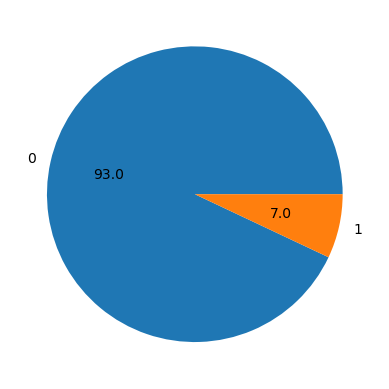

In [33]:
df.value_counts("SeriousDlqin2yrs").plot.pie(autopct = "%.1f")
plt.ylabel('')
plt.show()

We have already looked at some variables selectively. To do it more broadly, we can look at the pair plot of the dataset. A pair plot shows the pairwise relationships between the variables in our dataset. On the diagonal, we are plotting the kernel density estimate

/opt/anaconda3/envs/datascience_course_cemfi_dev/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


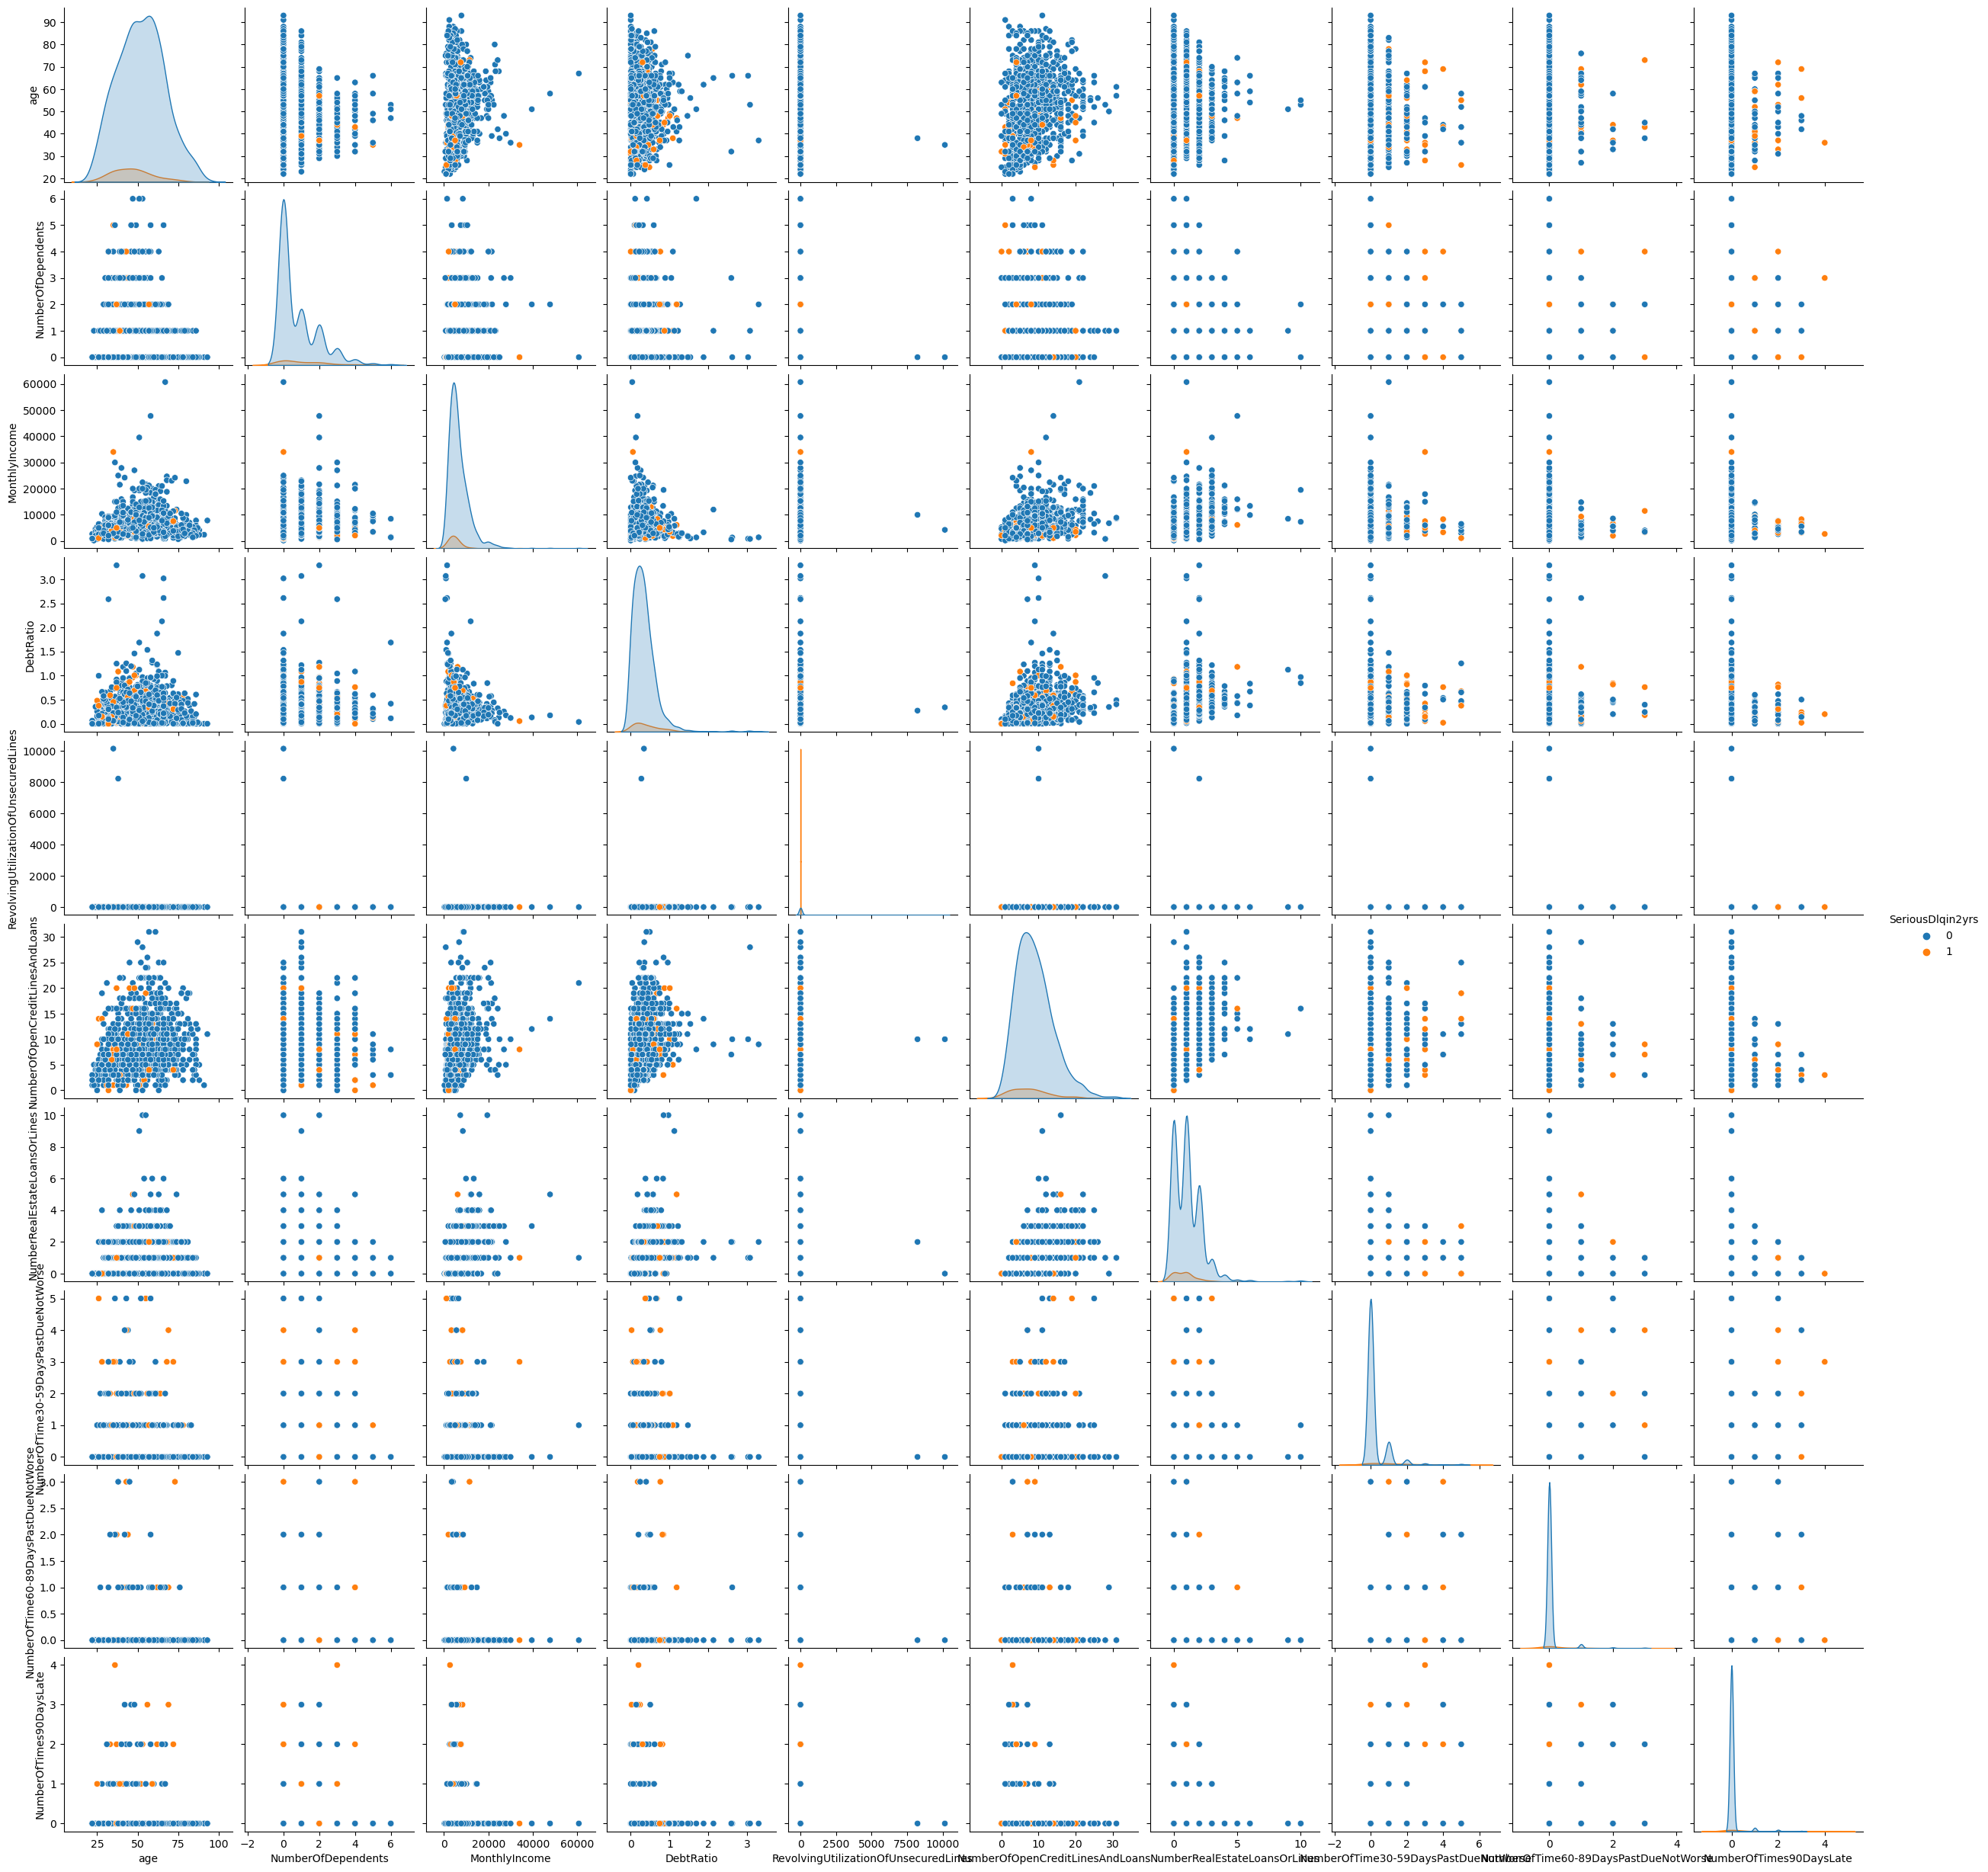

In [34]:
sns.pairplot(df.sample(1000), hue='SeriousDlqin2yrs')

Note that we are plotting all variables in different colors based on whether our target variable `SeriousDlqin2yrs` is $0$ or $1$. Furthermore, since it is computationally quite demanding to create this plot, we have sampled only 1000 rows from the dataset. Since we have many variables, some of them with very skewed distributions, and also several discrete variables, it might make sense to look only at a subset

/opt/anaconda3/envs/datascience_course_cemfi_dev/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


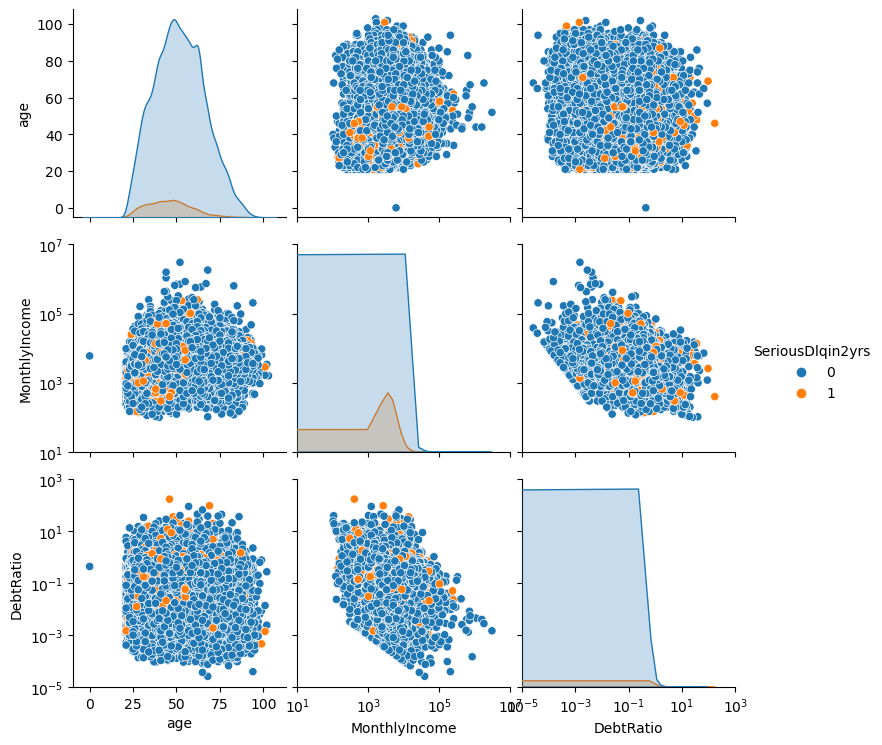

In [35]:
pp = sns.pairplot(df[['age', 'MonthlyIncome', 'DebtRatio', 'SeriousDlqin2yrs']], hue='SeriousDlqin2yrs')

# Fix the x-axis and y-axis scales
for ax in pp.axes.flat:
    if ax.get_xlabel() == 'MonthlyIncome':
        ax.set(xscale="log")
        ax.set_xlim(10**1, 10**7)
    if ax.get_ylabel() == 'MonthlyIncome':
        ax.set(yscale="log")
        ax.set_ylim(10**1, 10**7)

    if ax.get_xlabel() == 'DebtRatio':
        ax.set(xscale="log")
        ax.set_xlim(10**(-5), 10**3)
    if ax.get_ylabel() == 'DebtRatio':
        ax.set(yscale="log")
        ax.set_ylim(10**(-5), 10**3)

We can continue with the analysis of our dataset by looking at the correlation matrix of the variables in the dataset. We will calculate both the Pearson correlation (linear relationship) and the Spearman correlation (monotonic relationship) and create a heatmap of both correlation matrices

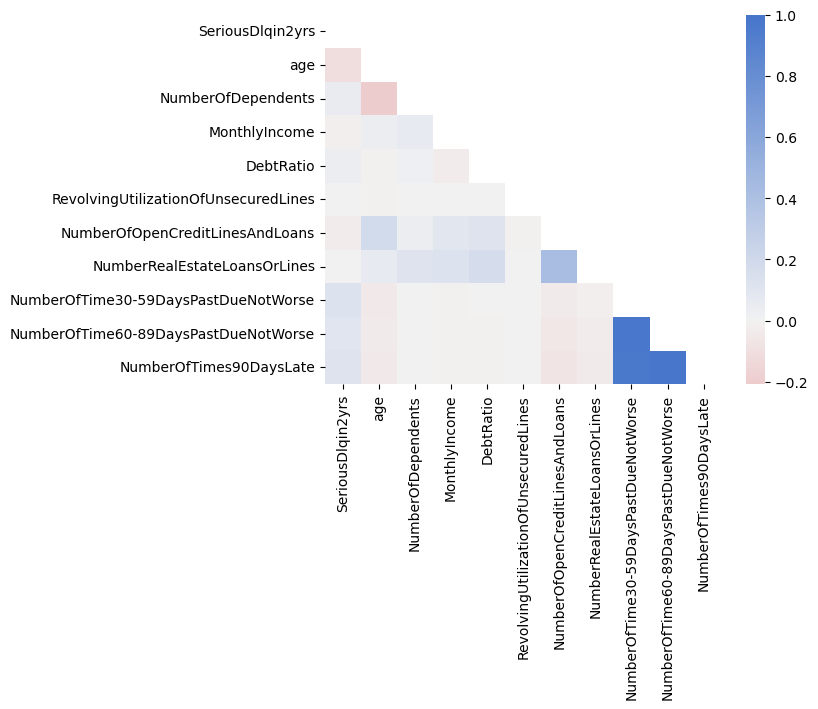

In [36]:
corr = df.corr() # Calculate the Pearson correlation (linear relationship)
cmap = sns.diverging_palette(10, 255, as_cmap=True) # Create a color map
mask = np.triu(np.ones_like(corr, dtype=bool)) # Create a mask to only show the lower triangle of the matrix
sns.heatmap(corr, cmap=cmap, vmax=1, center=0, mask=mask) # Create a heatmap of the correlation matrix (Note: vmax=1 makes sure that the color map goes up to 1 and center=0 are used to center the color map at 0)
plt.show()

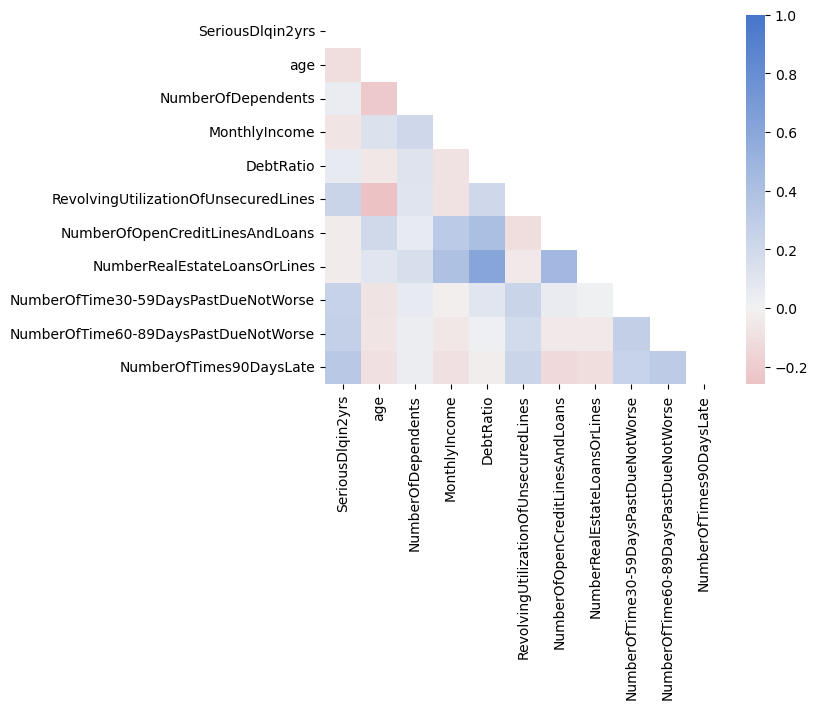

In [37]:
corr = df.corr('spearman') # Calculate the Spearman correlation (monotonic relationship)
cmap = sns.diverging_palette(10, 255, as_cmap=True) # Create a color map
mask = np.triu(np.ones_like(corr, dtype=bool)) # Create a mask to only show the lower triangle of the matrix
sns.heatmap(corr, cmap=cmap, vmax=1, center=0, mask=mask) # Create a heatmap of the correlation matrix (Note: vmax=1 makes sure that the color map goes up to 1 and center=0 are used to center the color map at 0)
plt.show()

It seems that `age` is negatively correlated with default (`SeriousDlqin2yrs`) which we can also see in the kernel density estimate of the `age` variable

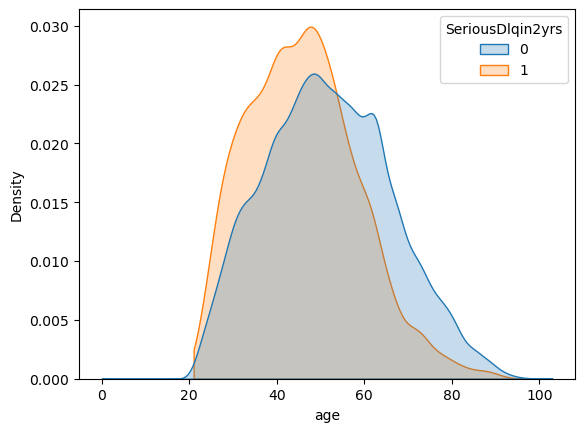

In [38]:
sns.kdeplot(data=df, x='age', hue='SeriousDlqin2yrs', cut=0, fill=True, common_norm=False)
plt.show()

but then `MonthlyIncome` is also negatively correlated with default and with `age`. Thus, likely the relationship between `age` and default is driven by `MonthlyIncome`.

Furthermore, the variables `NumberOfTime30-59DaysPastDueNotWorse`, `NumberOfTime60-89DaysPastDueNotWorse`, and `NumberOfTimes90DaysLate` are highly correlated with each other and with the target variable `SeriousDlqin2yrs`. This is not surprising given that these variables are all related to the number of times a borrower has been past due on a loan payment. `RevolvingUtilizationOfUnsecuredLines` is also highly correlated with the target variable and with the number of times a borrower has been past due on a loan payment. This is also not surprising given that the `RevolvingUtilizationOfUnsecuredLines` is the ratio of the amount of money owed to the amount of credit available.


## Implementation of Loan Default Prediction Models

We have explored our dataset and are now ready to implement machine learning algorithms for loan default prediction. Let's start by importing the required libraries

In [39]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, recall_score, precision_score, roc_curve
from joblib import dump, load

### Splitting the Data into Training and Test Sets

Before we can train a machine learning model, we need to split our dataset into a training set and a test set. 

In [40]:
X = df.drop('SeriousDlqin2yrs', axis=1) # All variables except `SeriousDlqin2yrs`
y = df['SeriousDlqin2yrs'] # Only SeriousDlqin2yrs

We follow @AlonsoRobisco2022 and use 80% of the data for training and 20% for testing. We will also set the `stratify` argument to `y` to make sure that the distribution of the target variable is the same in the training and test sets. Otherwise, we might randomly not have any defaulted loans in the test set, which would make it impossible to correctly evaluate our model.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)

### Scaling Features 

To improve the performance of our machine learning model, we should scale the features. This is especially important for models that are sensitive to the scale of the features. We will use the `MinMaxScaler` class from the `sklearn.preprocessing` module to scale the features. The `MinMaxScaler` class scales the features so that they have a minimum of 0 and a maximum of 1. 

In [42]:
def scale_features(scaler, df, col_names, only_transform=False):

    # Extract the features we want to scale
    features = df[col_names] 

    # Fit the scaler to the features and transform them
    if only_transform:
        features = scaler.transform(features.values)
    else:
        features = scaler.fit_transform(features.values)

    # Replace the original features with the scaled features
    df[col_names] = features

scaler = MinMaxScaler() 
scale_features(scaler, X_train, X_train.columns)
scale_features(scaler, X_test, X_test.columns, only_transform=True)

Note that we have very skewed distributions for some variables in our dataset. This might make the `MinMaxScaler` less effective and there might be gains from more carefully scaling different variables. However, for the sake of simplicity, we will use the `MinMaxScaler` for all variables.

We have fully preprocessed and explored our dataset. The next step will be our main task: the implementation of machine learning algorithms for loan default prediction.


### Evaluation Criertia

We will evaluate the performance of our machine-learning models using the following metrics:

* **Accuracy**: The proportion of correctly classified instances
* **Precision**: The proportion of true positive predictions among all positive predictions
* **Recall**: The proportion of true positive predictions among all actual positive instances
* **ROC AUC**: The area under the receiver operating characteristic curve

Furthermore, we will plot the ROC curve for each model to visualize the trade-off between the true positive rate and the false positive rate. To make the evaluation of our models more convenient, we will define a function that computes these metrics and plots the ROC curve for a given model

In [43]:
def evaluate_model(clf, X_train, y_train, X_test, y_test, label=''):

    # Compute predictions and probabilities for tha training and test set
    y_pred_train = clf.predict(X_train)
    y_proba_train = clf.predict_proba(X_train)
    y_pred_test = clf.predict(X_test)
    y_proba_test = clf.predict_proba(X_test)

    # Print accuracy measures
    print(f"--------------------------------------------------------------")
    print(f"Metrics: {label}")
    print(f"--------------------------------------------------------------")
    print(f"Accuracy (Train): {accuracy_score(y_train, y_pred_train)}")
    print(f"Precision (Train): {precision_score(y_train, y_pred_train)}")
    print(f"Recall (Train): {recall_score(y_train, y_pred_train)}")
    print(f"ROC AUC (Train): {roc_auc_score(y_train, y_proba_train[:, 1])}")
    print(f"--------------------------------------------------------------")
    print(f"Accuracy (Test): {accuracy_score(y_test, y_pred_test)}")
    print(f"Precision (Test): {precision_score(y_test, y_pred_test)}")
    print(f"Recall (Test): {recall_score(y_test, y_pred_test)}")
    print(f"ROC AUC (Test): {roc_auc_score(y_test, y_proba_test[:, 1])}")
    print(f"--------------------------------------------------------------")

    # Compute the ROC curve
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_proba_train[:, 1])
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_proba_test[:, 1])

    # Plot the ROC curve
    plt.plot(fpr_train, tpr_train, label = "Train") 
    plt.plot(fpr_test, tpr_test, label = "Test")
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve: {label}')
    plt.legend()
    plt.show()

While we compute all of these metrics, we will focus on the ROC AUC score as our main evaluation metric.


### Logistic Regression

Let's start with a simple logistic regression model. We will use the `LogisticRegression` class from the `sklearn.linear_model` module to train a logistic regression model. We will use the `lbfgs` solver and set the `max_iter` parameter to 5000 to make sure that the optimization algorithm converges. We will also set the `penalty` parameter to `None` to avoid regularization.

In [44]:
clf_logistic = LogisticRegression(penalty = None, solver = 'lbfgs', max_iter = 5000).fit(X_train, y_train)

Let's evaluate the performance of the logistic regression model

--------------------------------------------------------------
Metrics: Logistic Regression
--------------------------------------------------------------
Accuracy (Train): 0.9306588679085341
Precision (Train): 0.5787234042553191
Recall (Train): 0.041100030220610456
ROC AUC (Train): 0.6936171984517471
--------------------------------------------------------------
Accuracy (Test): 0.9302788844621513
Precision (Test): 0.5490196078431373
Recall (Test): 0.033836858006042296
ROC AUC (Test): 0.6926238627317243
--------------------------------------------------------------


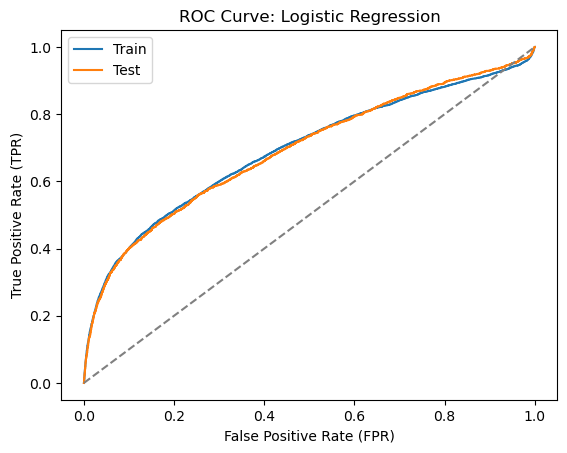

In [45]:
evaluate_model(clf_logistic, X_train, y_train, X_test, y_test, label = 'Logistic Regression')

The model does not perform as well as what we have seen in previous lectures. The ROC AUC score is only around 0.7. Note again that the accuracy score is quite high but this is due to the imbalanced nature of the dataset. 


### Decision Tree

Let's now train a decision tree classifier. We will use the `DecisionTreeClassifier` class from the `sklearn.tree` module to train a decision tree classifier. We will set the `max_depth` parameter to 7 as in @AlonsoRobisco2022 to avoid overfitting.

In [46]:
clf_tree = DecisionTreeClassifier(max_depth=7).fit(X_train, y_train)

Then, let's evaluate the performance of the decision tree classifier

--------------------------------------------------------------
Metrics: Decision Tree
--------------------------------------------------------------
Accuracy (Train): 0.936348994426431
Precision (Train): 0.6407185628742516
Recall (Train): 0.2101843457237836
ROC AUC (Train): 0.8265896261153018
--------------------------------------------------------------
Accuracy (Test): 0.9323556836483852
Precision (Test): 0.5529622980251346
Recall (Test): 0.18610271903323264
ROC AUC (Test): 0.8159823399376106
--------------------------------------------------------------


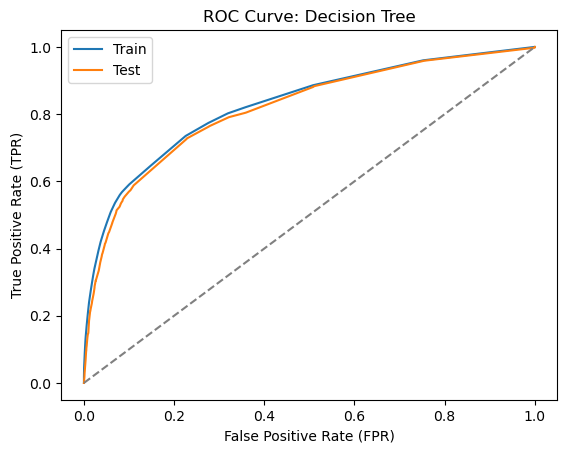

In [47]:
evaluate_model(clf_tree, X_train, y_train, X_test, y_test, label = 'Decision Tree')

The decision tree classifier performs better than the logistic regression model with a ROC AUC score of around 0.77. This is not surprising given that decision trees are more flexible models that can capture non-linear relationships in the data.


### Random Forest

Let's now train a random forest classifier. We will use the `RandomForestClassifier` class from the `sklearn.ensemble` module to train a random forest classifier. We will set the `max_depth` parameter to 20 and the `n_estimators` parameter to 100 as in @AlonsoRobisco2022.

In [48]:
clf_forest = RandomForestClassifier(max_depth=20, n_estimators = 100).fit(X_train, y_train)

Then, let's evaluate the performance of the random forest classifier

--------------------------------------------------------------
Metrics: Random Forest
--------------------------------------------------------------
Accuracy (Train): 0.976126899357874
Precision (Train): 1.0
Recall (Train): 0.6595648232094289
ROC AUC (Train): 0.9956114701590723
--------------------------------------------------------------
Accuracy (Test): 0.9321013817072137
Precision (Test): 0.5495327102803739
Recall (Test): 0.17764350453172206
ROC AUC (Test): 0.8400146575047622
--------------------------------------------------------------


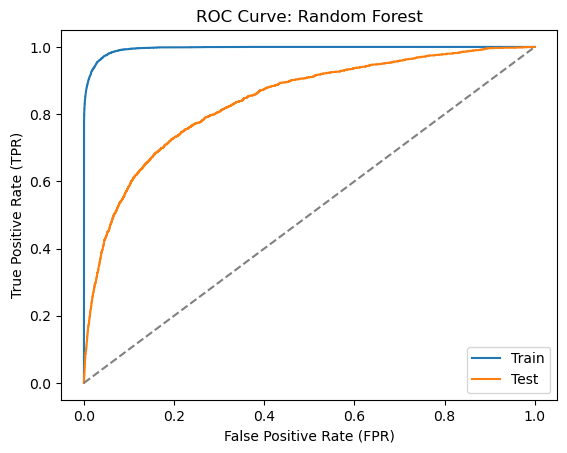

In [49]:
evaluate_model(clf_forest, X_train, y_train, X_test, y_test, label = 'Random Forest')

This is a good example of the dangers of not using a test set for the evaluation of a model. The random forest classifier performs very well on the training set with a ROC AUC score of close to 1.0. However, it performs much worse on the test set with a ROC AUC score of around 0.83. Nevertheless, the random forest classifier still outperforms the logistic regression and decision tree classifiers.


### XGBoost

Let's now train an XGBoost classifier. We will use the `XGBClassifier` class from the `xgboost` module to train an XGBoost classifier. We will set the `max_depth` parameter to 5 and the `n_estimators` parameter to 40 as in @AlonsoRobisco2022.

In [50]:
clf_xgb = XGBClassifier(max_depth = 5, n_estimators = 40, random_state = 0).fit(X_train, y_train)

Then, let's evaluate the performance of the XGBoost classifier

--------------------------------------------------------------
Metrics: XGBoost
--------------------------------------------------------------
Accuracy (Train): 0.9389238561468201
Precision (Train): 0.6947992700729927
Recall (Train): 0.23012994862496222
ROC AUC (Train): 0.8778826700467908
--------------------------------------------------------------
Accuracy (Test): 0.9330762058150377
Precision (Test): 0.5701107011070111
Recall (Test): 0.18670694864048337
ROC AUC (Test): 0.8514290998289821
--------------------------------------------------------------


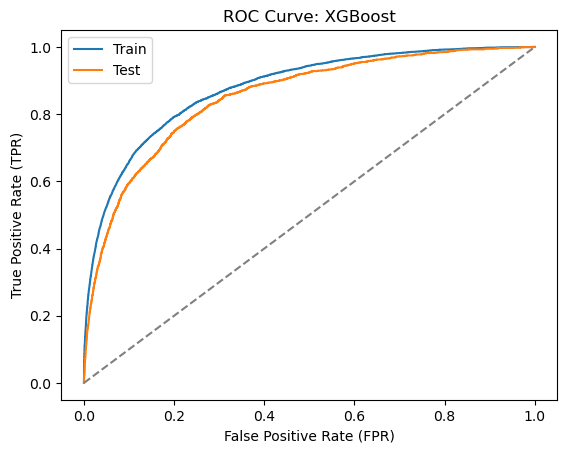

In [51]:
evaluate_model(clf_xgb, X_train, y_train, X_test, y_test, label = 'XGBoost')

The XGBoost classifier performs quite well with an ROC AUC score of around 0.83. This is the best performance we have seen so far.


### Neural Network

Finally, let's train a neural network classifier. We will use the `MLPClassifier` class from the `sklearn.neural_network` module to train a neural network classifier. We will set the `activation` parameter to `relu`, the `solver` parameter to `adam`, and the `hidden_layer_sizes` parameter to `(300,200,100)` as in @AlonsoRobisco2022. We will also set the `random_state` parameter to 42 to make the results reproducible.

In [52]:
#clf_nn = MLPClassifier(activation='relu', solver='adam', hidden_layer_sizes=(300,200,100), random_state=42, max_iter = 300, verbose=True).fit(X_train, y_train)
#dump(clf_nn, 'clf_nn.joblib') 

Since training the neural network classifier can take a long time, we have saved the trained model to a file called `clf_nn.joblib`. We can load the model from the file using the `load` function from the `joblib` module

In [53]:
clf_nn = load('clf_nn.joblib') 

Let's check the loss curve of the neural network classifier

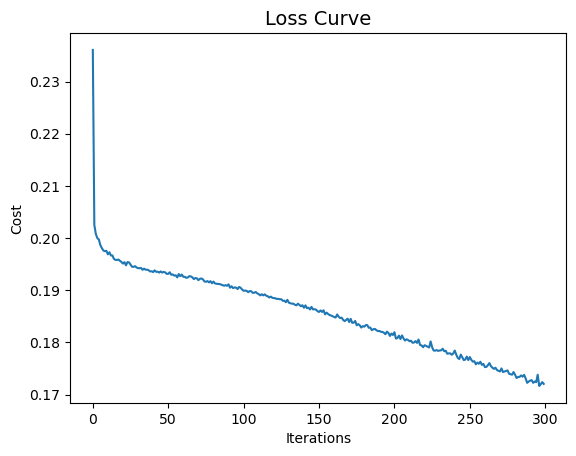

In [54]:
plt.plot(clf_nn.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

Then, let's evaluate the performance of the neural network classifier

--------------------------------------------------------------
Metrics: Neural Network
--------------------------------------------------------------
Accuracy (Train): 0.9465742683366182
Precision (Train): 0.8080531665363565
Recall (Train): 0.31233000906618313
ROC AUC (Train): 0.8682599095370773
--------------------------------------------------------------
Accuracy (Test): 0.9282020852759176
Precision (Test): 0.4694835680751174
Recall (Test): 0.18126888217522658
ROC AUC (Test): 0.7983637135044449
--------------------------------------------------------------


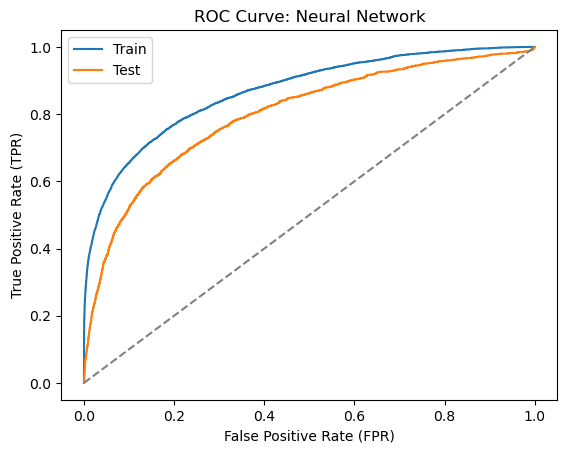

In [55]:
evaluate_model(clf_nn, X_train, y_train, X_test, y_test, label = 'Neural Network')

## Overview of the Results

Looking at all the models side by side, we can see that

In [56]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'Neural Network'],
    'ROC AUC (Train)': [roc_auc_score(y_train, clf_logistic.predict_proba(X_train)[:, 1]), 
                        roc_auc_score(y_train, clf_tree.predict_proba(X_train)[:, 1]), 
                        roc_auc_score(y_train, clf_forest.predict_proba(X_train)[:, 1]), 
                        roc_auc_score(y_train, clf_xgb.predict_proba(X_train)[:, 1]), 
                        roc_auc_score(y_train, clf_nn.predict_proba(X_train)[:, 1])],
    'ROC AUC (Test)': [roc_auc_score(y_test, clf_logistic.predict_proba(X_test)[:, 1]), 
                        roc_auc_score(y_test, clf_tree.predict_proba(X_test)[:, 1]), 
                        roc_auc_score(y_test, clf_forest.predict_proba(X_test)[:, 1]), 
                        roc_auc_score(y_test, clf_xgb.predict_proba(X_test)[:, 1]), 
                        roc_auc_score(y_test, clf_nn.predict_proba(X_test)[:, 1])]
})
results

,Model,ROC AUC (Train),ROC AUC (Test)
0,Logistic Regression,0.693617,0.692624
1,Decision Tree,0.826590,0.815982
2,Random Forest,0.995611,0.840015
3,XGBoost,0.877883,0.851429
4,Neural Network,0.868260,0.798364


But can we do better? @AlonsoRobisco2022 have also applied feature engineering to the dataset. Let's see if we can improve the performance of our models by adding some additional features.


## Feature Engineering and Model Improvement

We will add the square of each feature to the dataset to create additional features as in @AlonsoRobisco2022. We will use the `assign` method of the `pandas` DataFrame to add the squared features to the dataset

In [57]:
X2 = df.drop('SeriousDlqin2yrs', axis=1) # All variables except `SeriousDlqin2yrs`
y2 = df['SeriousDlqin2yrs'] # Only SeriousDlqin2yrs
X2 = X2.assign(**X2.pow(2).add_suffix('_sq')) # Add the squared features to the dataset

Then, we will split the dataset into a training set and a test set and scale the features

In [58]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, stratify=y2, test_size = 0.2, random_state = 42)
scaler = MinMaxScaler() 
scale_features(scaler, X2_train, X2_train.columns)
scale_features(scaler, X2_test, X2_test.columns, only_transform=True)

Let's train the models again with the new dataset and evaluate their performance

In [59]:
clf_logistic2 = LogisticRegression(penalty = None, solver = 'lbfgs', max_iter = 5000).fit(X2_train, y2_train)
clf_tree2 = DecisionTreeClassifier(max_depth=7).fit(X2_train, y2_train)
clf_forest2 = RandomForestClassifier(max_depth=20, n_estimators = 100).fit(X2_train, y2_train)
clf_xgb2 = XGBClassifier(max_depth = 5, n_estimators = 40, random_state = 0).fit(X2_train, y2_train)
#clf_nn2 = MLPClassifier(activation='relu', solver='adam', hidden_layer_sizes=(300,200,100), random_state=42, max_iter = 300, verbose=True).fit(X2_train, y2_train)
#dump(clf_nn2, 'clf_nn2.joblib') 

The neural network classifier takes a long time to train, so we will load the model from the file `clf_nn2.joblib` that we saved earlier

In [60]:
clf_nn2 = load('clf_nn2.joblib') 

Furthermore, we will also add a LASSO penalty to the logistic regression model to see if we can improve its performance

In [61]:
clf_logistic_lasso2 = LogisticRegression(penalty = 'l1', solver = 'liblinear').fit(X2_train, y2_train)

Let's evaluate the performance of the models with the new features in the dataset

In [62]:
results2 = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'Neural Network', 'Logistic LASSO'],
    'ROC AUC (Train)': [roc_auc_score(y2_train, clf_logistic2.predict_proba(X2_train)[:, 1]), 
                        roc_auc_score(y2_train, clf_tree2.predict_proba(X2_train)[:, 1]), 
                        roc_auc_score(y2_train, clf_forest2.predict_proba(X2_train)[:, 1]), 
                        roc_auc_score(y2_train, clf_xgb2.predict_proba(X2_train)[:, 1]), 
                        roc_auc_score(y2_train, clf_nn2.predict_proba(X2_train)[:, 1]),
                        roc_auc_score(y2_train, clf_logistic_lasso2.predict_proba(X2_train)[:, 1])
    ],
    'ROC AUC (Test)': [roc_auc_score(y2_test, clf_logistic2.predict_proba(X2_test)[:, 1]), 
                        roc_auc_score(y2_test, clf_tree2.predict_proba(X2_test)[:, 1]), 
                        roc_auc_score(y2_test, clf_forest2.predict_proba(X2_test)[:, 1]), 
                        roc_auc_score(y2_test, clf_xgb2.predict_proba(X2_test)[:, 1]), 
                        roc_auc_score(y2_test, clf_nn2.predict_proba(X2_test)[:, 1]),
                        roc_auc_score(y2_test, clf_logistic_lasso2.predict_proba(X2_test)[:, 1])
    ]
})
results2

,Model,ROC AUC (Train),ROC AUC (Test)
0,Logistic Regression,0.810256,0.813330
1,Decision Tree,0.826549,0.814273
2,Random Forest,0.994439,0.838450
3,XGBoost,0.877883,0.851429
4,Neural Network,0.871913,0.794420
5,Logistic LASSO,0.804410,0.810687


The models with the new features in the dataset perform better than the models without the new features. The random forest classifier and the XGBoost classifier have the best performance with ROC AUC scores of around 0.84 and 0.85, respectively. 


## Feature Importance

We can also look at the feature importance of the random forest classifier and the XGBoost classifier to see which features are most important for predicting loan defaults. We will use the `feature_importances_` attribute of the random forest classifier and the XGBoost classifier to get the feature importances

In [63]:
feature_importances_forest = clf_forest2.feature_importances_
feature_importances_xgb = clf_xgb2.feature_importances_

Then, we will create a bar plot of the feature importances for the random forest classifier and the XGBoost classifier

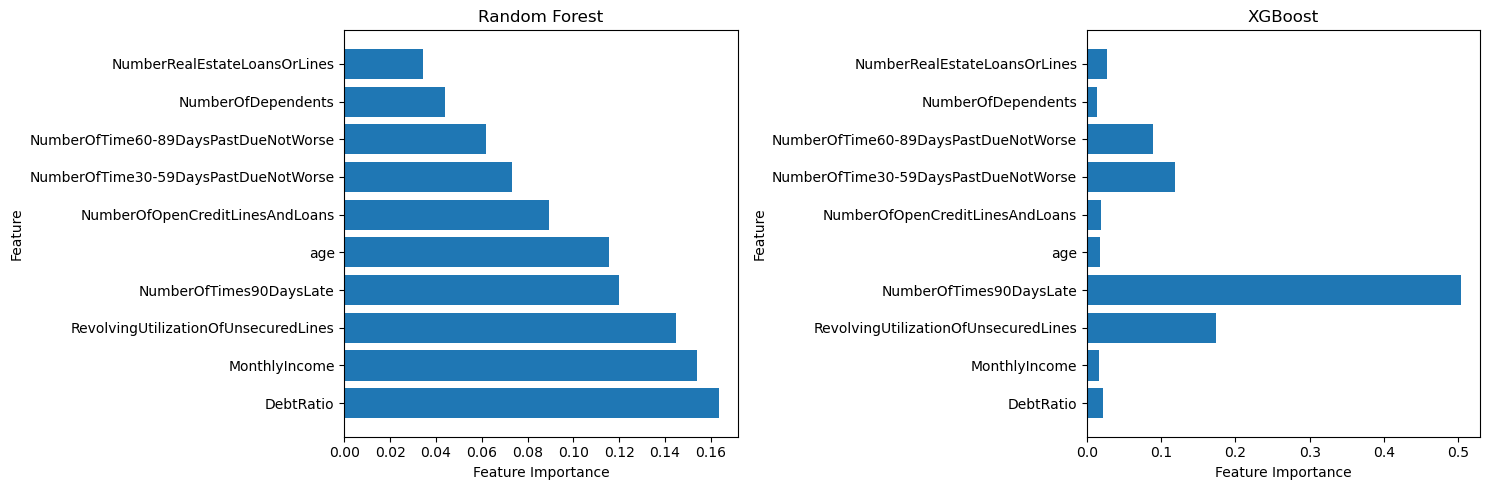

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

df_feature_importance_forest = pd.DataFrame({'Feature': X_train.columns, 'Importance': clf_forest.feature_importances_})
df_feature_importance_forest = df_feature_importance_forest.sort_values('Importance', ascending=False)

df_feature_importance_xgb = pd.DataFrame({'Feature': X_train.columns, 'Importance': clf_xgb.feature_importances_})
df_feature_importance_xgb = df_feature_importance_xgb.set_index('Feature')
df_feature_importance_xgb = df_feature_importance_xgb.loc[df_feature_importance_forest['Feature'], ]

# Random Forest
ax[0].barh(df_feature_importance_forest['Feature'], df_feature_importance_forest['Importance'])
ax[0].set_title('Random Forest')
ax[0].set_xlabel('Feature Importance')
ax[0].set_ylabel('Feature')

# XGBoost
ax[1].barh(df_feature_importance_forest['Feature'], df_feature_importance_xgb['Importance'])
ax[1].set_title('XGBoost')
ax[1].set_xlabel('Feature Importance')
ax[1].set_ylabel('Feature')

fig.tight_layout()
plt.show()

## Conclusions

We have successfully implemented machine learning algorithms for loan default prediction. We have explored the dataset, preprocessed the data, trained several machine learning models, and evaluated their performance. We have also applied feature engineering to the dataset and improved the performance of the models. The random forest classifier and the XGBoost classifier have the best performance with ROC AUC scores of around 0.84 and 0.85, respectively. We have also looked at the feature importance of the random forest classifier and the XGBoost classifier to see which features are most important for predicting loan defaults.